## 0. Setting up the Environment


In [1]:
## impoort labaries 
import os 
import cv2
import mat73
import time
import pandas as pd
import numpy as np 
import seaborn as sns
import skimage
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage.transform import resize
from keras.models import Sequential
from tensorflow.keras import optimizers
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D

## 1. Data Importing 

In [2]:
SIZE_X = 128
SIZE_Y = 128

aug_train_DF = pd.read_pickle(r"../../../Datasets/Dataset_B/aug_train_DF_{}.pkl".format(SIZE_X))
aug_val_DF = pd.read_pickle(r"../../../Datasets/Dataset_B/aug_val_DF_{}.pkl".format(SIZE_X))
aug_test_DF = pd.read_pickle(r"../../../Datasets/Dataset_B/aug_test_DF_{}.pkl".format(SIZE_X))

In [3]:
## Combain the df with the Pitutary & Meningioma types with the dataframe of the Glioma grades (I, II,, IV).

pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).sample(5)

,PID,Label,Image,File
2436,103478,Pituitary,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,...",1498.mat
11021,HF1490,Glioma III,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
13633,103582,Pituitary,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1506.mat
5313,102714,Meningioma,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",29.mat
8552,103478,Pituitary,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...",1686.mat


C:\Users\Ma7moud\anaconda3\envs\T-UNet\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


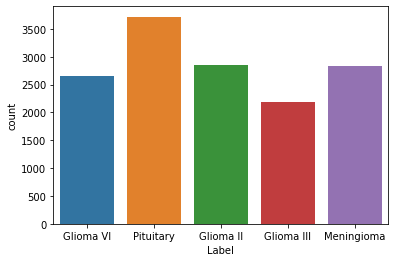

In [4]:
sns.countplot(pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).Label)
plt.show()

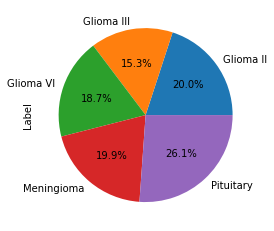

In [5]:
data = pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

## 2. Data-Preprocessing 

### 2.1 Image Resizing 


### 2.2 Data Augmentation

### 2.3 Grayscale to RGB

In [6]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')

In [7]:
aug_train_DF["Image"] = aug_train_DF["Image"].apply(normalize)
aug_val_DF["Image"] = aug_val_DF["Image"].apply(normalize)
aug_test_DF["Image"] = aug_test_DF["Image"].apply(normalize)

### 2.4 Splitting Data into Train, Test, and Validation Sets

In [8]:
y_train = aug_train_DF["Label"]
X_train = aug_train_DF['Image'].tolist()
X_train = np.array(X_train).reshape(-1, SIZE_X, SIZE_Y, 3)


y_val = aug_val_DF["Label"]
X_val = aug_val_DF['Image'].tolist()
X_val = np.array(X_val).reshape(-1, SIZE_X, SIZE_Y, 3)

y_test = aug_test_DF["Label"]
X_test = aug_test_DF['Image'].tolist()
X_test = np.array(X_test).reshape(-1, SIZE_X, SIZE_Y, 3)


### 2.5 Normalize Images to range from 0.0 to 1.0

In [9]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [10]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (10676, 128, 128, 3) | y_train shape: (10676,)
X_val shape  : (1424, 128, 128, 3)  | y_test shape :  (1424,)
X_test shape : (2136, 128, 128, 3)  | y_test shape :  (2136,)


### 2.6 One-Hot Encode the labels 

In [11]:
# saving a copy of the testing labels before one hot encoding
y_test_eval = y_test
# one hot endcoding the labels 
y_train = pd.get_dummies(y_train)
y_test  = pd.get_dummies(y_test)
y_val   = pd.get_dummies(y_val)

In [12]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_test shape :",X_test.shape," | y_test shape: ", y_test.shape)
print("X_val shape  :",X_val.shape," | y_val shape : ", y_val.shape)
print("\nTotal number: {}".format(len(aug_train_DF)+len(aug_val_DF)+len(aug_test_DF)))

X_train shape: (10676, 128, 128, 3) | y_train shape: (10676, 5)
X_test shape : (2136, 128, 128, 3)  | y_test shape:  (2136, 5)
X_val shape  : (1424, 128, 128, 3)  | y_val shape :  (1424, 5)

Total number: 14236


In [13]:
y_test

,Glioma II,Glioma III,Glioma VI,Meningioma,Pituitary
0,1,0,0,0,0
1,0,0,0,0,1
2,1,0,0,0,0
3,0,0,0,1,0
4,0,0,0,0,1
...,...,...,...,...,...
2131,0,0,0,0,1
2132,1,0,0,0,0
2133,0,0,0,0,1
2134,0,0,1,0,0


In [14]:
## This Dictionary is used to decode the model's predicted values.  
decode_dict = {0 : "Glioma II", 1 : "Glioma III", 2 : "Glioma VI", 3: "Meningioma", 4: "Pituitary"}

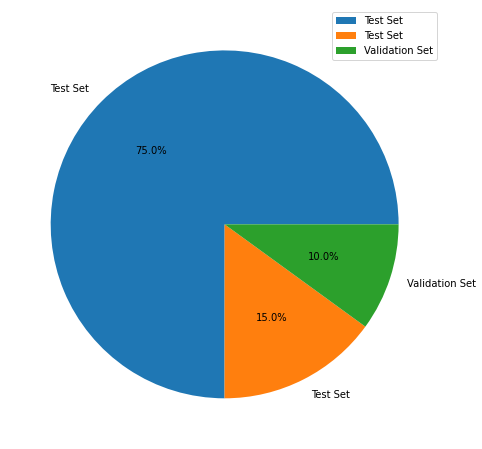

In [15]:
import matplotlib.pyplot as plt
import numpy as np
##  Creating a Pie chart illustrating the percentage of the train, validation, test sets.
Data = np.array([len(y_train), len(y_test), len(y_val)])
mylabels = ["Test Set", "Test Set", "Validation Set"]
plt.figure(figsize=(13, 8))
plt.pie(Data, labels = mylabels, autopct="%.1f%%", )
plt.legend()
plt.show() 

## 3. Models Creation


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D, Input, Lambda
import tensorflow as tf
import time
from tensorflow.keras import optimizers
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from glob import glob



InceptionV3 = InceptionV3(include_top=False, weights=None, input_shape = (SIZE_X, SIZE_Y, 3))

for layer in InceptionV3.layers:
    layer.trainable = False

# Dense Lyers
x = Flatten()(InceptionV3.output)
outLayers = Dense(5, activation='softmax')(x)

m1 = Model(inputs = InceptionV3.input, outputs = outLayers)

m1.summary()
m1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### 4. Model Training


In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10 )

m1.fit(X_train,y_train,epochs=150, validation_data=(X_val,y_val), callbacks = [early_stop], verbose=1)

Epoch 1/150
334/334 [==============================] - 16s 31ms/step - loss: 1.5959 - accuracy: 0.2673 - val_loss: 1.5905 - val_accuracy: 0.2725
Epoch 2/150
334/334 [==============================] - 8s 23ms/step - loss: 1.5879 - accuracy: 0.2675 - val_loss: 1.5863 - val_accuracy: 0.2725
Epoch 3/150
334/334 [==============================] - 8s 23ms/step - loss: 1.5847 - accuracy: 0.2675 - val_loss: 1.5830 - val_accuracy: 0.2725
Epoch 4/150
334/334 [==============================] - 8s 23ms/step - loss: 1.5815 - accuracy: 0.2675 - val_loss: 1.5802 - val_accuracy: 0.2725
Epoch 5/150
334/334 [==============================] - 8s 23ms/step - loss: 1.5783 - accuracy: 0.2675 - val_loss: 1.5763 - val_accuracy: 0.2725
Epoch 6/150
334/334 [==============================] - 8s 23ms/step - loss: 1.5752 - accuracy: 0.2675 - val_loss: 1.5733 - val_accuracy: 0.2725
Epoch 7/150
334/334 [==============================] - 8s 23ms/step - loss: 1.5720 - accuracy: 0.2675 - val_loss: 1.5695 - val_accuracy

334/334 [==============================] - 8s 24ms/step - loss: 1.4564 - accuracy: 0.3971 - val_loss: 1.4457 - val_accuracy: 0.3848
Epoch 58/150
334/334 [==============================] - 8s 23ms/step - loss: 1.4546 - accuracy: 0.3982 - val_loss: 1.4435 - val_accuracy: 0.3778
Epoch 59/150
334/334 [==============================] - 8s 23ms/step - loss: 1.4530 - accuracy: 0.3987 - val_loss: 1.4415 - val_accuracy: 0.3841
Epoch 60/150
334/334 [==============================] - 8s 23ms/step - loss: 1.4511 - accuracy: 0.4009 - val_loss: 1.4398 - val_accuracy: 0.3975
Epoch 61/150
334/334 [==============================] - 8s 23ms/step - loss: 1.4495 - accuracy: 0.4004 - val_loss: 1.4386 - val_accuracy: 0.3989
Epoch 62/150
334/334 [==============================] - 8s 23ms/step - loss: 1.4478 - accuracy: 0.4040 - val_loss: 1.4365 - val_accuracy: 0.4073
Epoch 63/150
334/334 [==============================] - 8s 23ms/step - loss: 1.4461 - accuracy: 0.4070 - val_loss: 1.4348 - val_accuracy: 0.402

334/334 [==============================] - 8s 23ms/step - loss: 1.3773 - accuracy: 0.4649 - val_loss: 1.3601 - val_accuracy: 0.4768
Epoch 114/150
334/334 [==============================] - 8s 23ms/step - loss: 1.3759 - accuracy: 0.4716 - val_loss: 1.3598 - val_accuracy: 0.4663
Epoch 115/150
334/334 [==============================] - 8s 23ms/step - loss: 1.3750 - accuracy: 0.4638 - val_loss: 1.3576 - val_accuracy: 0.4789
Epoch 116/150
334/334 [==============================] - 8s 23ms/step - loss: 1.3739 - accuracy: 0.4718 - val_loss: 1.3566 - val_accuracy: 0.4712
Epoch 117/150
334/334 [==============================] - 8s 23ms/step - loss: 1.3727 - accuracy: 0.4700 - val_loss: 1.3552 - val_accuracy: 0.4747
Epoch 118/150
334/334 [==============================] - 8s 23ms/step - loss: 1.3716 - accuracy: 0.4694 - val_loss: 1.3544 - val_accuracy: 0.4733
Epoch 119/150
334/334 [==============================] - 8s 24ms/step - loss: 1.3705 - accuracy: 0.4721 - val_loss: 1.3530 - val_accuracy:

In [18]:
# Get training history
metrics = pd.DataFrame(m1.history.history)

In [19]:
# Evaluate the model's accuarcy 
m1.evaluate(X_test, y_test)

67/67 [==============================] - 2s 31ms/step - loss: 1.3543 - accuracy: 0.4359


[1.3542840480804443, 0.43586140871047974]

In [20]:
import os
exp_num = []
if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))


if len(exp_num) == 0:
    exp_path = r"./experiments/exp#1"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [21]:
print(results)

./experiments/exp#6\results


In [22]:
# Save The Trained model along with it training history   
Accuracy = m1.evaluate(X_test, y_test)[-1]
name = str(round(Accuracy, 4))

metrics.to_pickle(os.path.join(results, name+'.pkl'))
m1.save(os.path.join(weights, name + '.h5'))

67/67 [==============================] - 1s 21ms/step - loss: 1.3543 - accuracy: 0.4359


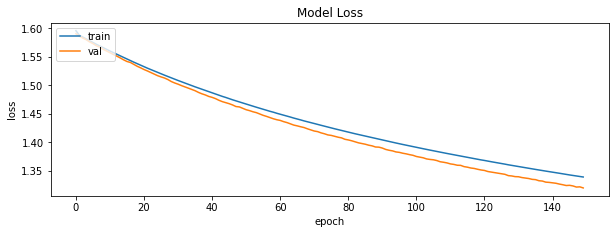

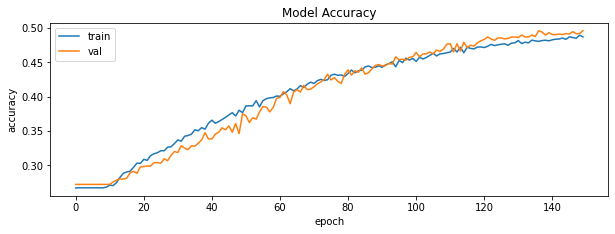

In [23]:
## Dispaly the plot of 
rows = 2
columns = 1
  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.plot(metrics['loss'])
plt.plot(metrics['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.show()

  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 2)
plt.plot(metrics['accuracy'])
plt.plot(metrics['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'acc_epoch.png'))
plt.show()



In [24]:
## Get the 
predict_x = m1.predict(X_test) 
predictions = np.argmax(predict_x,axis=1) 

In [25]:
# Decode the Model's predections  (from [0,1,0,2..] to ['Glioma','Meningioma'...]) of the Test set using the the dictionary 'decode_dict' 
predictions = np.vectorize(decode_dict.get)(predictions)

In [26]:
print(classification_report(y_test_eval, predictions))

              precision    recall  f1-score   support

   Glioma II       0.29      0.22      0.25       428
  Glioma III       0.60      0.24      0.35       356
   Glioma VI       0.30      0.22      0.25       420
  Meningioma       0.50      0.43      0.46       456
   Pituitary       0.48      0.97      0.64       476

    accuracy                           0.44      2136
   macro avg       0.43      0.42      0.39      2136
weighted avg       0.43      0.44      0.40      2136



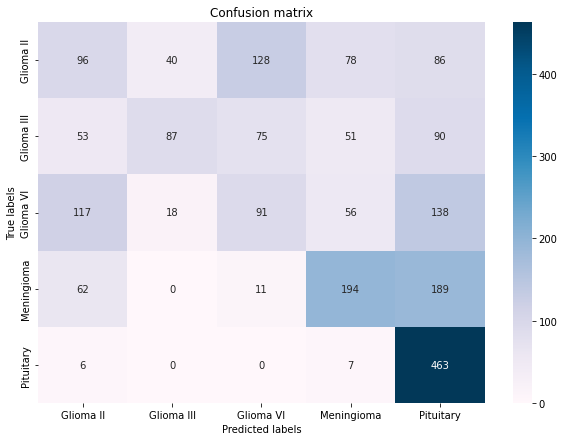

In [27]:
labels = sorted(["Glioma II", "Glioma III", "Glioma VI", "Meningioma", "Pituitary"])

cm = pd.DataFrame(confusion_matrix(y_test_eval, predictions), index=labels, columns=labels)
plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, cmap="PuBu",fmt = 'd')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(os.path.join(results, 'confusion_matrix.png'))
plt.show()